Using features v2

Loading and preprocessing data...

Preparing features...

Training XGBoost model...

=== Fold 1 ===
Class distribution after SMOTE:
Counter({'1': 18860, 'W': 18860, '2': 18860, '3': 18860, 'R': 18860, 'NAN': 18860})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 Accuracy: 0.4587

=== Fold 2 ===
Class distribution after SMOTE:
Counter({'1': 18860, 'W': 18860, '2': 18860, '3': 18860, 'R': 18860, 'NAN': 18860})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 Accuracy: 0.4648

=== Fold 3 ===
Class distribution after SMOTE:
Counter({'1': 18860, 'W': 18860, '2': 18860, '3': 18860, 'R': 18860, 'NAN': 18860})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 Accuracy: 0.4513

=== Fold 4 ===
Class distribution after SMOTE:
Counter({'1': 18860, 'W': 18860, '2': 18860, '3': 18860, 'R': 18860, 'NAN': 18860})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 Accuracy: 0.4711

=== Fold 5 ===
Class distribution after SMOTE:
Counter({'1': 18860, 'W': 18860, '2': 18860, '3': 18860, 'R': 18860, 'NAN': 18860})


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:39:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 Accuracy: 0.4450

=== Overall Evaluation ===

Classification Report:
              precision    recall  f1-score   support

           1     0.1344    0.0990    0.1140      3344
           2     0.6718    0.4792    0.5594     23575
           3     0.1985    0.8474    0.3216      1363
         NAN     0.6561    1.0000    0.7924       374
           R     0.4399    0.4184    0.4289     10299
           W     0.3435    0.5118    0.4111      7124

    accuracy                         0.4582     46079
   macro avg     0.4074    0.5593    0.4379     46079
weighted avg     0.5161    0.4582    0.4698     46079



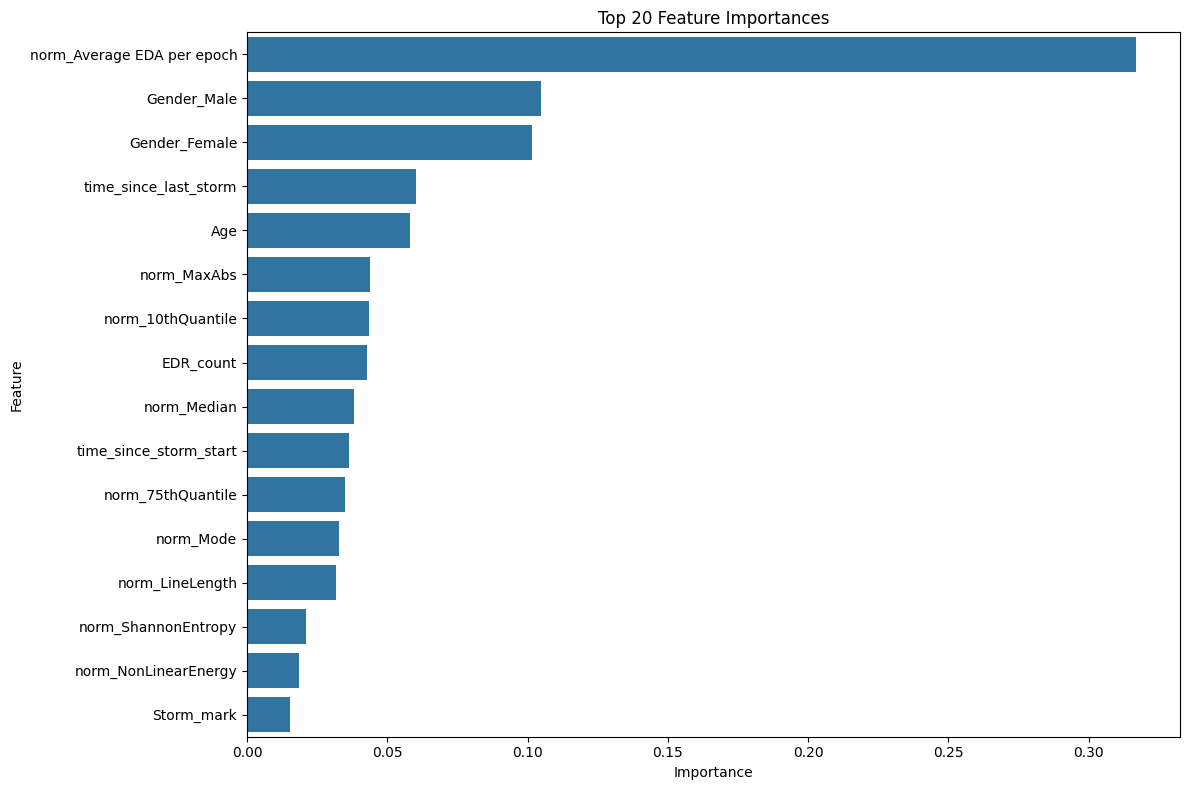

In [6]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib

# 1. Data Loading and Preparation (Updated)
def load_and_preprocess_data(features_dir):
    """Load and combine all patient feature files with proper type conversion"""
    feature_files = glob.glob(os.path.join(features_dir, "*.csv"))
    dfs = []
    
    for file in feature_files:
        try:
            df = pd.read_csv(file)
            
            # Convert sleep stage to string and standardize
            if 'Sleep_stage' in df.columns:
                df['Sleep_stage'] = df['Sleep_stage'].astype(str).str.upper().str.strip()
                # df['Sleep_stage'] = df['Sleep_stage'].replace({
                #     '1': '1', '2': '2', '3': '3', 
                #     'R': 'R', 'W': 'W',
                #     'N1': '1', 'N2': '2', 'N3': '3', 
                #     'REM': 'R', 'WAKE': 'W'
                # })
            
            # Convert Gender to categorical
            if 'Gender' in df.columns:
                df['Gender'] = df['Gender'].astype('category')
            
            # Convert numeric columns (handle errors)
            numeric_cols = ['Mode', 'Median', 'MaxAbs', 'LineLength', '10thQuantile', 
                          '75thQuantile', 'NonLinearEnergy', 'ShannonEntropy',
                          'Average EDA per epoch', 'EDR_count', 'Storm_mark', 'Age',
                          'time_since_storm_start', 'time_since_last_storm']
            
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
            
            # Extract patient ID if not present
            if 'patient_id' not in df.columns:
                patient_id = os.path.basename(file).split('_')[0]
                df['patient_id'] = patient_id
            
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Drop unnecessary columns
    combined_df = combined_df.drop(columns=['SVD_Entropy', 'Date_E4_synced'], errors='ignore')
    
    return combined_df

# 2. Feature Engineering (Updated with proper encoding)
def preprocess_features(df):
    """Handle all feature preprocessing including categorical encoding"""
    # Normalize features by subject
    features_to_normalize = ['Mode', 'Median', 'MaxAbs', 'LineLength', '10thQuantile', 
                           '75thQuantile', 'NonLinearEnergy', 'ShannonEntropy', 
                           'Average EDA per epoch']
    
    for feat in features_to_normalize:
        if feat in df.columns:
            df[f'norm_{feat}'] = df.groupby('patient_id')[feat].transform(
                lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
            ).fillna(0)
    
    # Add temporal features
    df = df.sort_values(['patient_id', 'time_since_storm_start'])
    le = LabelEncoder()
    all_stages = pd.concat([df['Sleep_stage'], df['Sleep_stage'].shift(1)])
    le.fit(all_stages.dropna().unique())
    df['prev_stage'] = le.transform(df.groupby('patient_id')['Sleep_stage'].shift(1).fillna('W'))
    
    # Prepare final feature set
    normalized_features = [f'norm_{f}' for f in features_to_normalize if f in df.columns]
    other_features = ['EDR_count', 'Storm_mark', 'Age', 'Gender', 'prev_stage',
                     'time_since_storm_start', 'time_since_last_storm']
    
    # Select only features that exist in the dataframe
    available_features = normalized_features + [f for f in other_features if f in df.columns]
    X = df[available_features]
    y = df['Sleep_stage']
    
    # Encode target variable
    y_encoded = le.transform(y)
    
    return X, y_encoded, le

# 3. Model Training (Updated with proper categorical handling)
def train_xgboost_model(X, y, le, n_splits=5):
    """Train and evaluate XGBoost model with proper feature encoding"""
    # Convert categorical columns (like Gender) using one-hot encoding
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='drop'
    )
    
    # Initialize Stratified K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store results
    all_y_test = []
    all_y_pred = []
    feature_importances = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Fold {fold} ===")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Preprocess features
        X_train_processed = preprocessor.fit_transform(X_train)
        X_test_processed = preprocessor.transform(X_test)
        
        # Apply SMOTE only to training data
        try:
            smote = SMOTE(random_state=42)
            X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)
            print("Class distribution after SMOTE:")
            print(Counter(le.inverse_transform(y_train_res)))
        except Exception as e:
            print(f"SMOTE failed: {e}. Using original distribution.")
            X_train_res, y_train_res = X_train_processed.copy(), y_train.copy()
        
        # XGBoost parameters
        xgb_model = xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=len(le.classes_),
            max_depth=3,
            learning_rate=0.05,
            subsample=1.0,
            colsample_bytree=1.0,
            eval_metric=['mlogloss', 'merror'],
            n_estimators=200,
            random_state=42,
            use_label_encoder=False
        )
        
        # Train model
        xgb_model.fit(X_train_res, y_train_res)
        
        # Predict
        y_pred = xgb_model.predict(X_test_processed)
        
        # Store results
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        feature_importances.append(xgb_model.feature_importances_)
        
        # Print fold results
        print(f"Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Overall evaluation
    print("\n=== Overall Evaluation ===")
    print("\nClassification Report:")
    print(classification_report(all_y_test, all_y_pred, target_names=le.classes_, digits=4))
    
    # Feature names after one-hot encoding
    feature_names = numeric_cols.copy()
    if len(categorical_cols) > 0:
        ohe = preprocessor.named_transformers_['cat']
        for i, col in enumerate(categorical_cols):
            for category in ohe.categories_[i]:
                feature_names.append(f"{col}_{category}")
    
    # Feature Importance
    avg_importance = np.mean(feature_importances, axis=0)
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return xgb_model, preprocessor, feat_imp_df

# Main Execution
if __name__ == "__main__":
    # Configuration
    DATA_DIR = r"C:\Users\LENOVO\OneDrive - American University of Beirut\FYP 2024-25 ECE\FYP_Fall_2024-2025\ML Implementation\XGBOOST_first_try\Features_v2"  # Update this path
    OUTPUT_MODEL = "sleep_stage_xgboost_model.pkl"
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(DATA_DIR)
    
    # Prepare features and target
    print("\nPreparing features...")
    X, y, le = preprocess_features(data)
    
    # Train and evaluate model
    print("\nTraining XGBoost model...")
    model, preprocessor, feature_importances = train_xgboost_model(X, y, le)
    
    # # Save model components
    # joblib.dump({
    #     'model': model,
    #     'preprocessor': preprocessor,
    #     'label_encoder': le,
    #     'feature_importances': feature_importances
    # }, OUTPUT_MODEL)
    
    # print(f"\nModel saved to {OUTPUT_MODEL}")

In [ ]:
# Create and train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(label_encoder.classes_),  # number of sleep stages
    eval_metric='mlogloss',  # appropriate for multi-class
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Print accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature importance
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)